In [88]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import datetime as dt
import seaborn as sns
import tensorflow as tf


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

In [89]:
df = pd.read_csv("Dataset.csv")
tickers = df.groupby('Ticker')
dates = df.date.unique()
dates = [dt.datetime.strptime(d,'%m/%d/%Y').date() for d in dates]

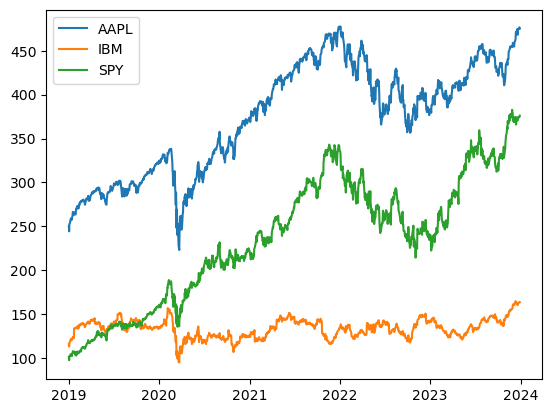

In [90]:
for name, data in tickers:
    plt.plot(dates, data.PRC.values, '-', label = name)
plt.legend()

In [91]:
'''
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps].flatten() for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps:idx + feature_steps + target_steps][:, -1]
                  for idx in range(n_obs)])
    return X, y
    '''
def ts_split(ts, feature_steps=10, target_steps=1):
    n_obs = len(ts) - feature_steps - target_steps + 1
    X = np.array([ts[idx:idx + feature_steps] for idx in range(n_obs)])
    y = np.array([ts[idx + feature_steps] for idx in range(n_obs)])  # Extract all features as the target
    return X, y


In [92]:
ts = {}
X = {}
y = {}
X_train_full = {}
y_train_full = {}
X_test = {}
y_test = {}
X_train = {}
y_train = {}
X_valid = {}
y_valid = {}
split_ind = {}
split_ind_2 = {}

features = ['PRC','ASKHI', 'BID']  # Example features
scalers = {}

# Initialize dictionaries to store original target values
original_y_train = {}
original_y_valid = {}
original_y_test = {}


In [ ]:
from sklearn.preprocessing import MinMaxScaler

# The variables are already defined in CELL INDEX: 6, no need to redefine them
#target = 'PRC'  # Define the target column

for name, data in tickers:
    data = data[features].dropna()
   
    scalers[name] = MinMaxScaler()
    data[features] = scalers[name].fit_transform(data[features])
    ts[name] = data[features].values
    
    X[name], y[name] = ts_split(ts[name])
    split_ind[name] = int(X[name].shape[0] * 0.8)
    X_train_full[name], y_train_full[name] = X[name][:split_ind[name]], y[name][:split_ind[name]]
    X_test[name], y_test[name] = X[name][split_ind[name]:], y[name][split_ind[name]:]
    split_ind_2[name] = int(X_train_full[name].shape[0] * 0.8)
    X_train[name], y_train[name] = X_train_full[name][:split_ind_2[name]], y_train_full[name][:split_ind_2[name]]
    X_valid[name], y_valid[name] = X_train_full[name][split_ind_2[name]:], y_train_full[name][split_ind_2[name]:]

In [94]:

print(len(y_train_full['SPY']))
print(len(X_train_full['SPY']))
print(y_test['SPY'][1])
print(X_train['SPY'].shape)
print(data[features].shape)

998
998
[0.46161937 0.46701161 0.4617461 ]
(798, 10, 3)
(1258, 3)


In [96]:
print(X_train['SPY'].shape)
print(y_train['SPY'].shape)

(798, 10, 3)
(798, 3)


Test loss for AAPL: 0.8666552901268005
Training model for ticker: AAPL
X_train shape: (798, 10, 3), y_train shape: (798, 3)
X_valid shape: (200, 10, 3), y_valid shape: (200, 3)


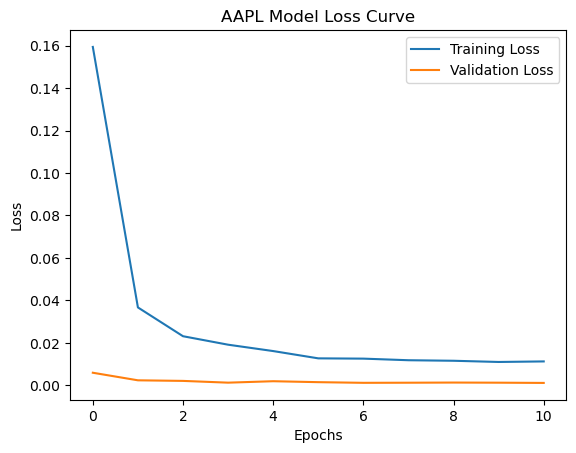

Test loss for IBM: 0.3207625448703766
Training model for ticker: IBM
X_train shape: (798, 10, 3), y_train shape: (798, 3)
X_valid shape: (200, 10, 3), y_valid shape: (200, 3)


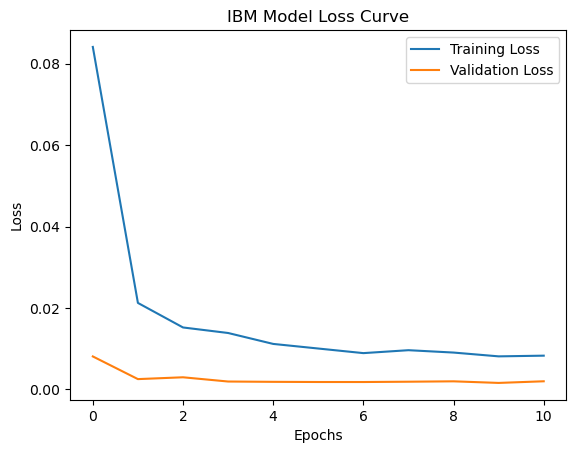

Test loss for SPY: 0.8883718848228455
Training model for ticker: SPY
X_train shape: (798, 10, 3), y_train shape: (798, 3)
X_valid shape: (200, 10, 3), y_valid shape: (200, 3)


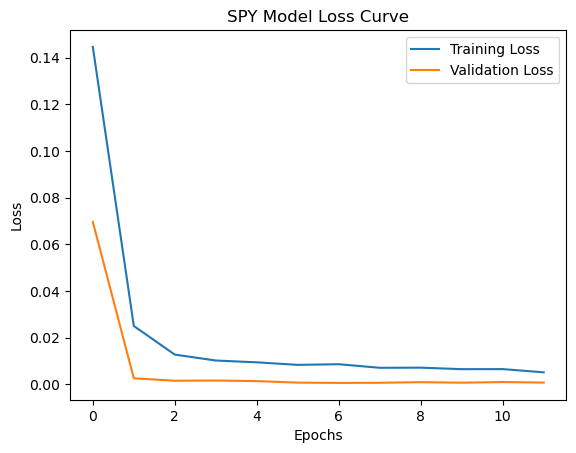

In [97]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense, Dropout

models = {}
histories = {}

for name in tickers.groups.keys():
    # Determine input shape for the RNN (timesteps, features)
    input_shape = (X_train[name].shape[1], X_train[name].shape[2])  # Assuming X_train is (samples, timesteps, features)
    output_units = y_train[name].shape[1] if len(y_train[name].shape) > 1 else 1  # Determine number of output units
    
    # Build RNN model
    model = Sequential()
    model.add(SimpleRNN(units=50, activation='relu', input_shape=input_shape))  # You can switch to LSTM or GRU if needed
    model.add(Dropout(0.2))  # Add dropout for regularization
    model.add(Dense(units=output_units))  # Output layer
    model.compile(optimizer='adam', loss='mean_squared_error')  # Compile the model
    
    y_train_values = y_train[name]  # Keep the y values without reshaping
    y_valid_values = y_valid[name]  # Validation y values without reshaping
    test_loss = model.evaluate(X_test[name], y_test[name], verbose=0)
    print(f"Test loss for {name}: {test_loss}")
    
    # X_train and X_valid are already correctly shaped for RNN (no need for reshaping here)
    print(f"Training model for ticker: {name}")
    print(f"X_train shape: {X_train[name].shape}, y_train shape: {y_train_values.shape}")
    print(f"X_valid shape: {X_valid[name].shape}, y_valid shape: {y_valid_values.shape}")
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=10,
                                                min_delta=0.01,
                                                restore_best_weights=True)
    # Ensure X and y have matching number of samples
    if len(X_train[name]) == len(y_train_values):
        history = model.fit(X_train[name], y_train_values, epochs=20, batch_size=32,
                            validation_data=(X_valid[name], y_valid_values),
                            callbacks=[early_stopping_cb], verbose=0)
        models[name] = model
        histories[name] = history
        
        
        # Plotting loss curves
        plt.figure()
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title(f"{name} Model Loss Curve")
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
    else:
        print(f"Data cardinality mismatch for {name}: X_train has {len(X_train[name])} samples, "
              f"y_train has {len(y_train_values)} samples")


In [ ]:
print

8/8 [==============================] - 0s 2ms/step
Ticker: AAPL - MSE: 0.0058017177897908


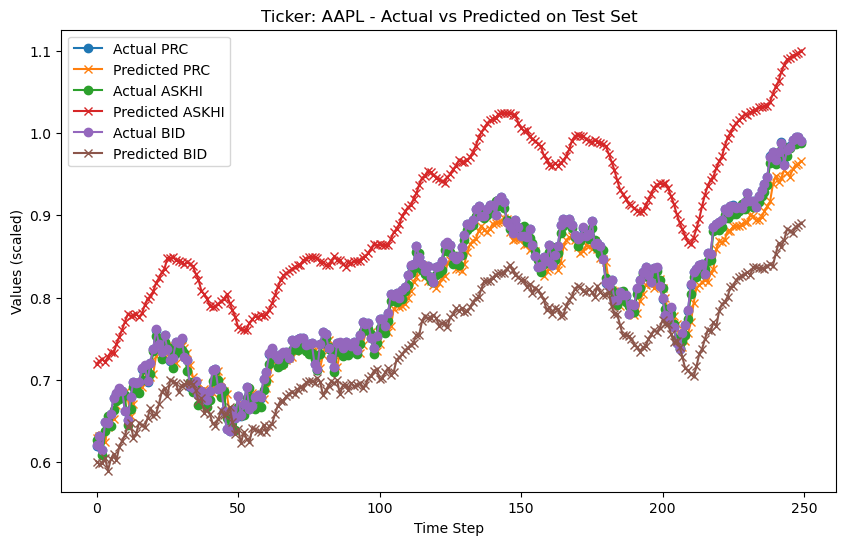

8/8 [==============================] - 0s 3ms/step
Ticker: IBM - MSE: 0.011494998706737737


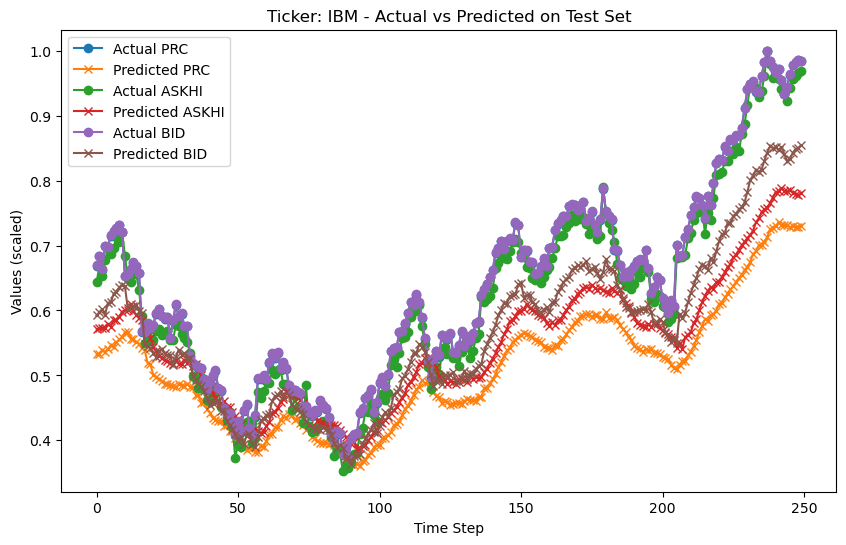

8/8 [==============================] - 0s 1ms/step
Ticker: SPY - MSE: 0.006189786464339891


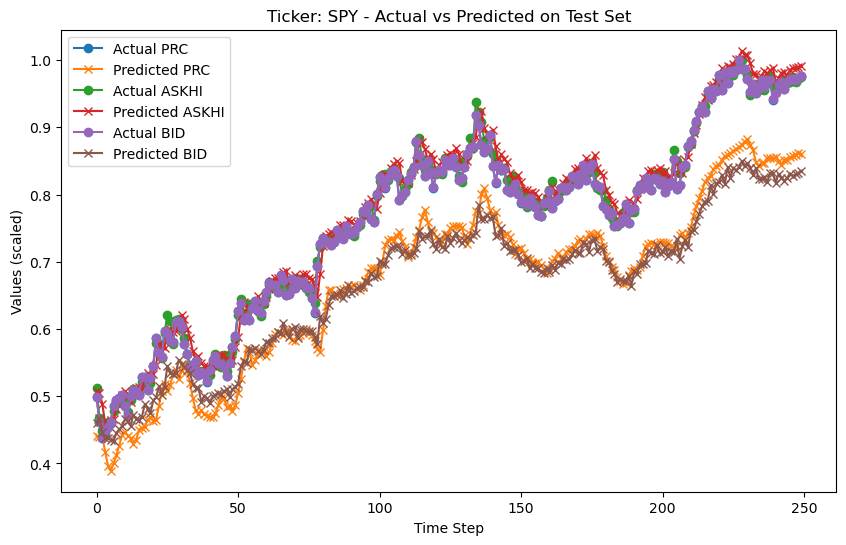

In [98]:
from sklearn.metrics import mean_squared_error

# Plotting the model's prediction on the test set for each ticker

for name, model in models.items():
    X_test_values = X_test[name]  # Use the correctly shaped X_test values

    y_test_values = y_test[name]
    y_pred = model.predict(X_test_values)
    
    y_test_original = scalers[name].inverse_transform(y_test_values)
    y_pred_original = scalers[name].inverse_transform(y_pred)

    # Adjust for single or multiple output features
    y_test_values = y_test_values.reshape(-1, 1) if len(y_test_values.shape) == 1 else y_test_values
    y_pred = y_pred.reshape(-1, 1) if len(y_pred.shape) == 1 else y_pred
    
    mse = mean_squared_error(y_test_values, y_pred)
    print(f'Ticker: {name} - MSE: {mse}')

    # Plotting actual vs predicted for each feature
    plt.figure(figsize=(10, 6))
    for i, feature in enumerate(features):
        if y_test_values.shape[1] > i:  # Ensure index is within bounds
            plt.plot(range(len(y_test_values)), y_test_values[:, i], label=f'Actual {feature}', linestyle='-', marker='o')
            plt.plot(range(len(y_pred)), y_pred[:, i], label=f'Predicted {feature}', linestyle='-', marker='x')
    plt.title(f'Ticker: {name} - Actual vs Predicted on Test Set')
    plt.xlabel('Time Step')
    plt.ylabel('Values (scaled)')
    plt.legend()
    plt.show()

8/8 [==============================] - 0s 4ms/step
Ticker: AAPL - MSE: 16.493066444413614
Test Loss: 0.0019594556652009487


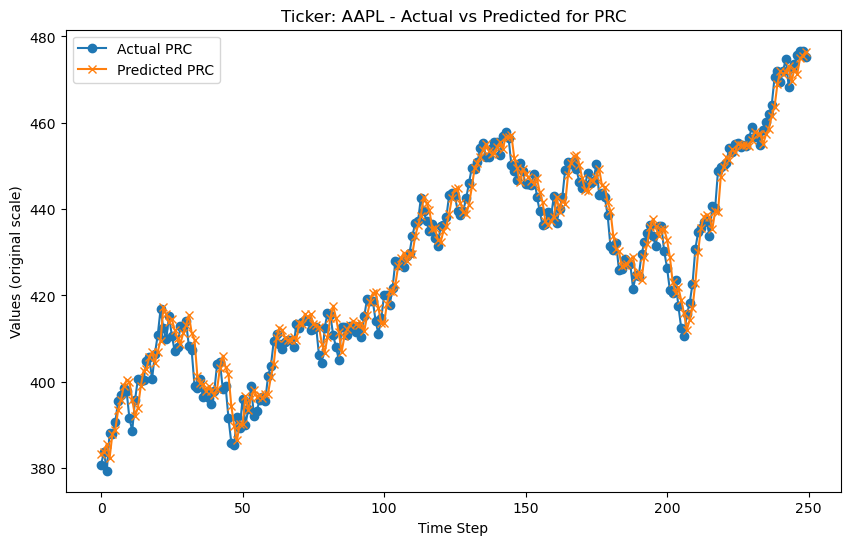

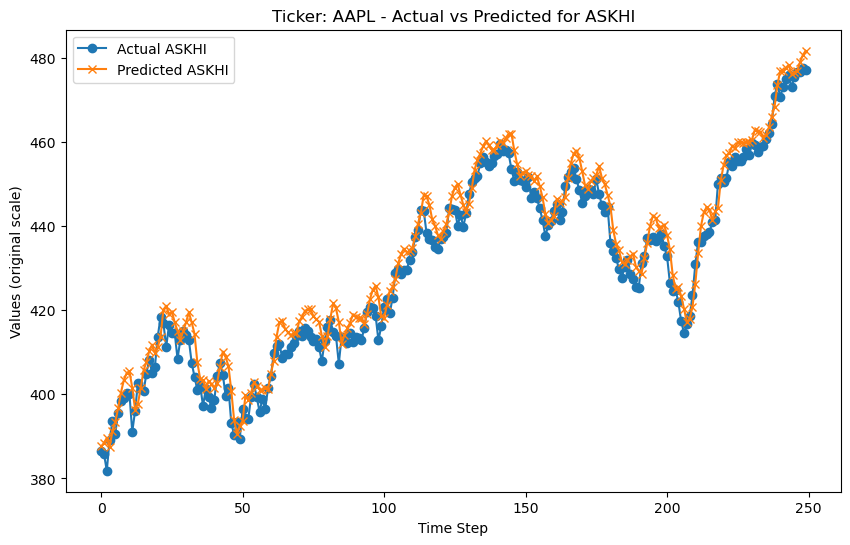

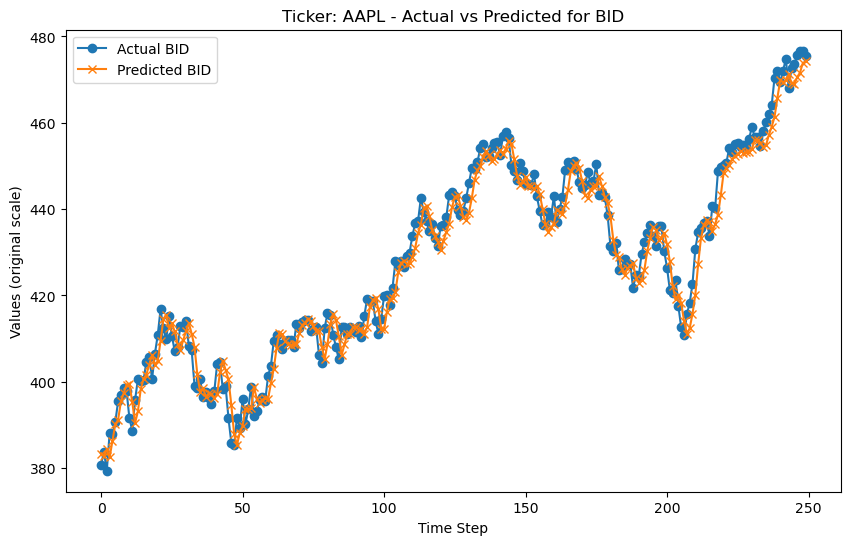

8/8 [==============================] - 0s 2ms/step
Ticker: IBM - MSE: 6.001483854922989
Test Loss: 0.0015748435398563743


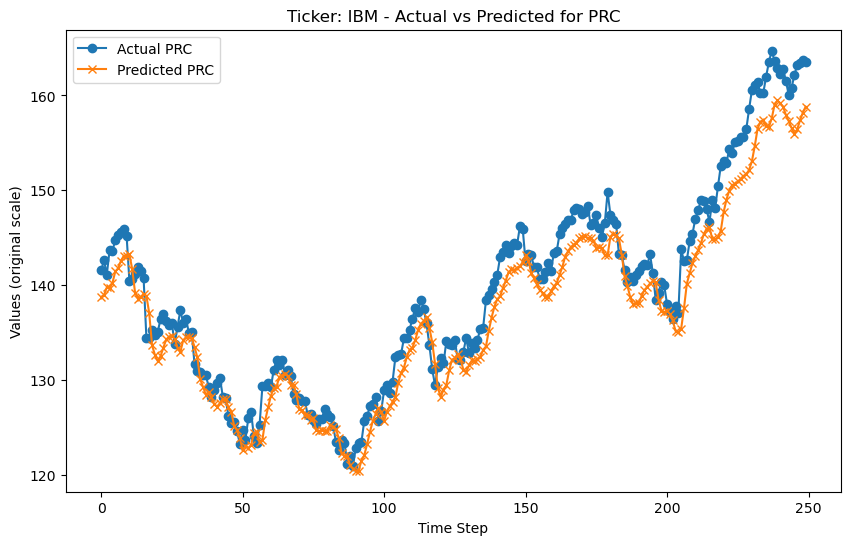

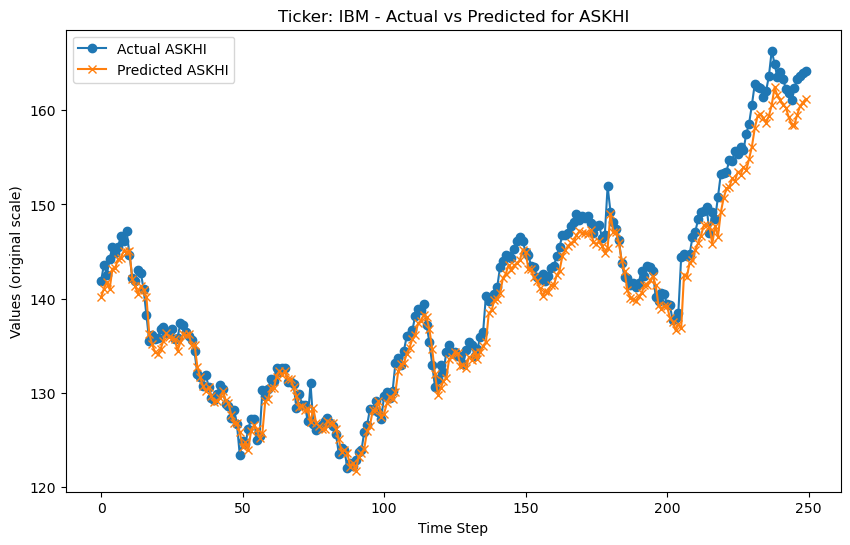

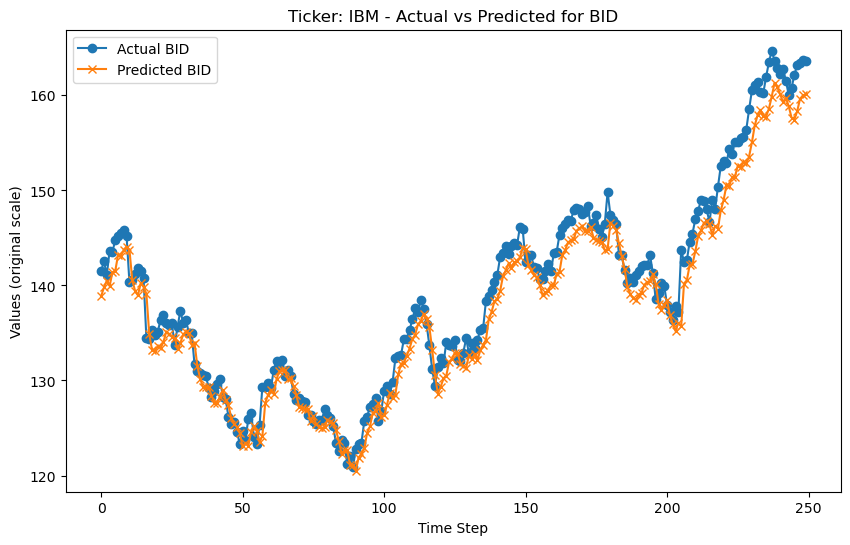

8/8 [==============================] - 0s 2ms/step
Ticker: SPY - MSE: 165.3828676980308
Test Loss: 0.00203606765717268


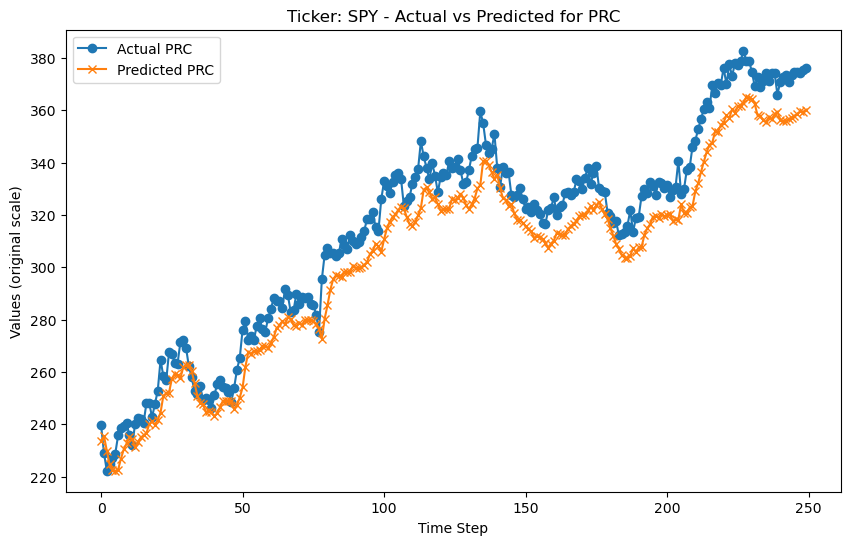

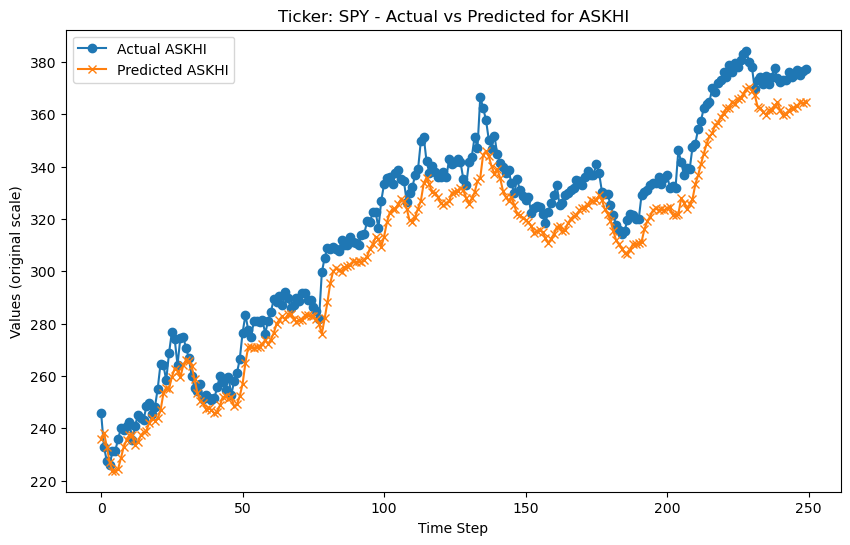

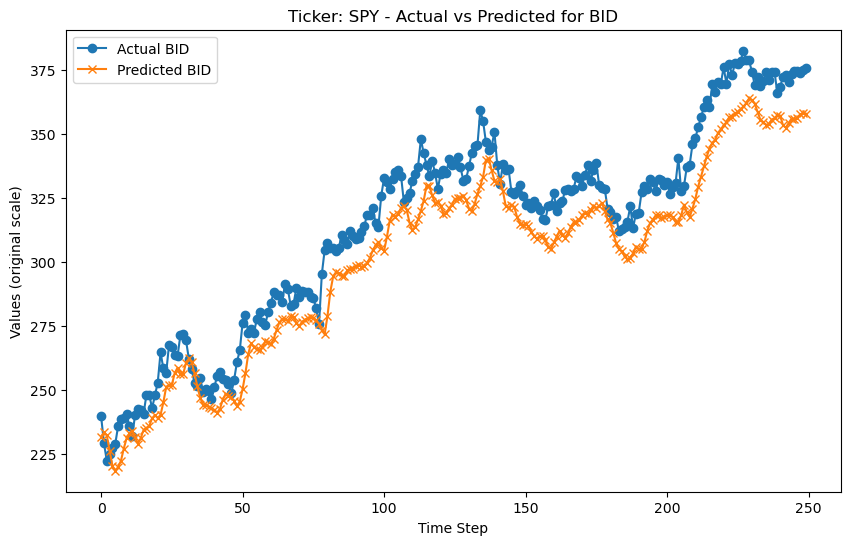

In [ ]:
# Loop through each ticker
for name in tickers.groups.keys():
    # Make predictions for the current ticker
    y_test_values = y_test[name]
    y_pred = models[name].predict(X_test[name])

    # Inverse transform predictions and test values to original scale
    y_test_original = scalers[name].inverse_transform(y_test_values)
    y_pred_original = scalers[name].inverse_transform(y_pred)
    mse = mean_squared_error(y_test_original, y_pred_original)
    print(f'Ticker: {name} - MSE: {mse}')
    # Evaluate on a separate test set if available
   
    print(f"Test Loss: {test_loss}")


    # Loop through each feature to plot separately
    for i, feature in enumerate(features):
        if y_test_original.shape[1] > i:  # Ensure index is within bounds
            plt.figure(figsize=(10, 6))
            plt.plot(range(len(y_test_original)), y_test_original[:, i], label=f'Actual {feature}', linestyle='-', marker='o')
            plt.plot(range(len(y_pred_original)), y_pred_original[:, i], label=f'Predicted {feature}', linestyle='-', marker='x')
            plt.title(f'Ticker: {name} - Actual vs Predicted for {feature}')
            plt.xlabel('Time Step')
            plt.ylabel('Values (original scale)')
            plt.legend()
            plt.show()


In [79]:
print(y_train['SPY'].shape)
print(y_test['SPY'].shape)
print(y_valid['SPY'].shape)
print(y_train_full['SPY'].shape)
print(X_test['SPY'].shape)
print(len(data[features]))

(798, 3)
(250, 3)
(200, 3)
(998, 3)
(250, 10, 3)
1258
